<h1>Analysis of Azog C1 chip: Bloch oscillations</h1>
Online analysis script used to pre-analyse the data collected during the cooldown of the chip.

In [1]:
sample_name = 'azog_c1'                    # name of the chip in the fridge
date_suffixe = '20220201'
user = 'ncr'                               # who is performing measurements

<h3>Basic imports</h3>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from resonator_tools import circuit

import qcodes as qc
from qcodes import initialise_database, load_by_run_spec
from qcodes.dataset.plotting import plot_by_id

import scipy.optimize

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

<h2>Data analysis and plotting</h2>

In [3]:
db_name = 'bloch_oscillations_v1.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',date_suffixe+'_'+user+'_'+ db_name)

qc.initialise_or_create_database_at(db_path)

In [5]:
qc.experiments()

[iv_curves#azog_c1#1@D:\QMET\azog_c1\20220201_ncr_bloch_oscillations_v1.db
 -------------------------------------------------------------------------
 1-iv_mwoff_pm10mV-1-adwin_input_2_voltage_up,adwin_input_2_voltage_down,adwin_up_ramp,adwin_down_ramp,mw_source_frequency,mw_source_power-40000
 2-iv_mwoff_pm10mV_slow-2-adwin_input_2_voltage_up,adwin_input_2_voltage_down,adwin_up_ramp,adwin_down_ramp,mw_source_frequency,mw_source_power-31998
 3-iv_mwoff_pm10mV_slow-3-adwin_input_2_voltage_up,adwin_input_2_voltage_down,adwin_up_ramp,adwin_down_ramp,mw_source_frequency,mw_source_power-31998
 4-iv_mwon_f315p-35pm5mV-4-adwin_input_2_voltage_up,adwin_input_2_voltage_down,adwin_up_ramp,adwin_down_ramp,mw_source_frequency,mw_source_power-31998
 5-iv_mwon_f404p-55pm5mV-5-adwin_input_2_voltage_up,adwin_input_2_voltage_down,adwin_up_ramp,adwin_down_ramp,mw_source_frequency,mw_source_power-31998
 6-iv_mwon_f544p32pm5mV-6-adwin_input_2_voltage_up,adwin_input_2_voltage_down,adwin_up_ramp,adwin_down_

<h4>IV with and without microwaves</h4>

In [4]:
# mw off
RUN_ID = 57
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mwoff_df_dict = dataset.to_pandas_dataframe_dict()

# mw 3.20GHz
RUN_ID = 88
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mw315_df_dict = dataset.to_pandas_dataframe_dict()

# mw 4.04GHz
RUN_ID = 36 # 5 
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mw404_df_dict = dataset.to_pandas_dataframe_dict()

# mw 5.44GHz
RUN_ID = 43 # 6 42
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mw544_df_dict = dataset.to_pandas_dataframe_dict()

# mw 6.11Hz
RUN_ID = 7 # 7
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mw611_df_dict = dataset.to_pandas_dataframe_dict()

# mw 6.46GHz
RUN_ID = 48 # 8 49
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mw646_df_dict = dataset.to_pandas_dataframe_dict()

# mw 7.49GHz
RUN_ID = 9
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mw749_df_dict = dataset.to_pandas_dataframe_dict()

ivmw_runs = [ mwoff_df_dict, mw315_df_dict, mw404_df_dict, mw544_df_dict, mw611_df_dict,mw646_df_dict, mw749_df_dict]

<h5>Data shaping</h5>

In [5]:
V_lh = []
I_lh = []
V_hl = []
I_hl = []

for run in ivmw_runs:
    
    # up ramps
    run_up_0 = run['adwin_up_ramp']
    run_up_1 = run_up_0.reset_index()
    v_up = run_up_1['adwin_input_2_voltage_up'].to_numpy()
    i_up = run_up_1['adwin_up_ramp'].to_numpy()
    
    # down ramps
    run_down_0 = run['adwin_down_ramp']
    run_down_1 = run_down_0.reset_index()
    v_down = run_down_1['adwin_input_2_voltage_down'].to_numpy()
    i_down = run_down_1['adwin_down_ramp'].to_numpy()
    
    # divide into low-to-high and high-to-low
    N = len(v_up)
    zero_index_up = np.argmin(np.abs(i_up))
    zero_index_down = np.argmin(np.abs(i_down))

    v_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
    V_lh.append(v_lh)
    i_lh = np.concatenate(( np.flip(i_down[zero_index_down:]), i_up[zero_index_up:] ))
    I_lh.append(i_lh)
    
    v_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
    i_hl = np.concatenate(( i_up[:zero_index_up], np.flip(i_down[:zero_index_down]) ))
    V_hl.append(v_hl)
    I_hl.append(i_hl)    

<h5>Plotting</h5>

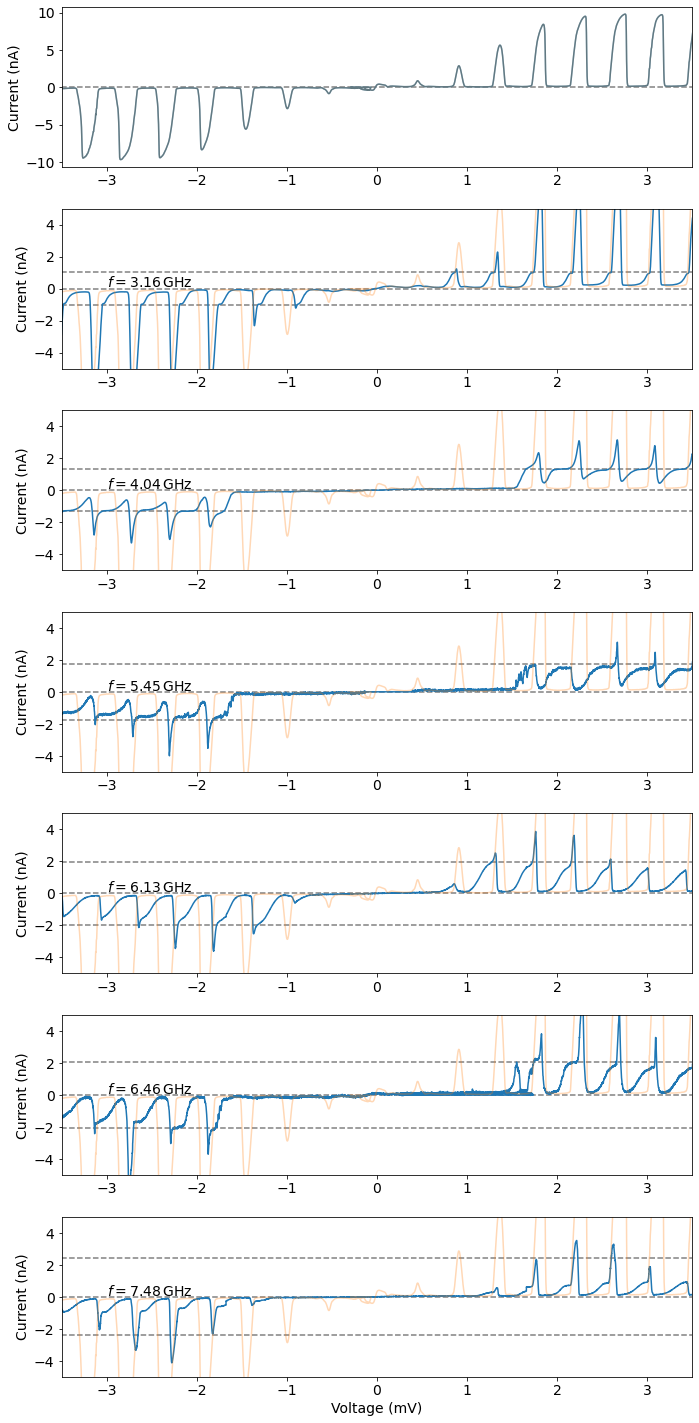

In [6]:
e = 1.6e-19
frequencies = [ 0, 3.16e9, 4.04e9, 5.45e9, 6.13e9, 6.46e9, 7.48e9]
steps_number = len(frequencies)

voltage_scale = 1e3
current_scale = 1e9
xrange_mv = 3.5

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(steps_number, 1, figsize=(10,20))

# plot all
for index in range(steps_number):
    
    ax[index].plot(voltage_scale*V_lh[index], current_scale*I_lh[index])
    ax[index].plot(voltage_scale*V_lh[0], current_scale*I_lh[0], alpha=0.3)
    ax[index].set_xlim([-xrange_mv, xrange_mv])
    ax[index].set_ylabel('Current (nA)')
    
    ax[index].hlines(0, -5, 5, linestyles='dashed', colors='black', alpha=0.5)
    if (index != 0):
        ax[index].text( -3, 0.1, '$f =%s \,\mathrm{GHz}$' % (frequencies[index]/1e9) )
        ax[index].hlines(2*e*frequencies[index]*current_scale, -5, 5, linestyles='dashed', colors='black', alpha=0.5)
        ax[index].hlines(-2*e*frequencies[index]*current_scale, -5, 5, linestyles='dashed', colors='black', alpha=0.5)
        ax[index].set_ylim([-5,5])

ax[-1].set_xlabel('Voltage (mV)')
fig.tight_layout()

# plt.savefig('iv_f.png')

<h4>Steps for different power levels</h4>

In [7]:
# mw 4.04GHz
RUN_ID = 22 
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
mw404ps_df_dict = dataset.to_pandas_dataframe_dict()

In [8]:
# IV curve
mw404ps_up_0 = mw404ps_df_dict['adwin_up_ramp']
mw404ps_up_1 = mw404ps_up_0.reset_index()
mwp_up = mw404ps_up_1['mw_source_power'].to_numpy()
v_up = mw404ps_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = mw404ps_up_1['adwin_up_ramp'].to_numpy()

# down ramp
mw404ps_down_0 = mw404ps_df_dict['adwin_down_ramp']
mw404ps_down_1 = mw404ps_down_0.reset_index()
mwp_down = mw404ps_down_1['mw_source_power'].to_numpy()
v_down = mw404ps_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = mw404ps_down_1['adwin_down_ramp'].to_numpy()

# reshape to form a 2D array
N = 10000 # hardcoded for now
size = (-1, N)

v_up = np.reshape(v_up, size)
i_up = np.reshape(i_up, size)
v_down = np.reshape(v_down, size)
i_down = np.reshape(i_down, size)
mwp_up = np.reshape(mwp_up, size)
mwp_down = np.reshape(mwp_down, size)

C:\Users\NICOLA~1.ROC\AppData\Local\Temp/ipykernel_15232/2472682200.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


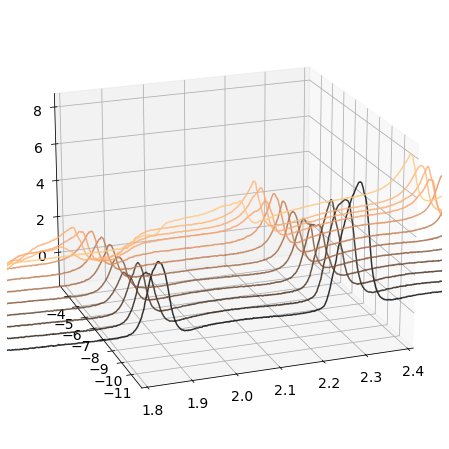

<Figure size 720x576 with 0 Axes>

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

e = 1.6e-19
f = 4.04e9
voltage_scale = 1e3
current_scale = 1e9

fig = plt.figure(figsize=(14,8))
ax = fig.gca(projection='3d')

plt.figure(figsize=(10,8))
for pw in [0,10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 100]:
    color_index = np.linspace(0,1,101)
    ax.plot(voltage_scale*v_up[pw], mwp_up[pw], current_scale*i_up[pw], color=plt.cm.copper(color_index[pw]), alpha=0.8)
    
ax.set_xlim([1.8,2.4])
ax.view_init(elev=20., azim=-110)

<h4>S21 as a function of DC voltage with microwaves</h4>

In [10]:
# loading vna data
RUN_ID = 55
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()

RUN_ID = 36 # 36, 58
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_dc_dict = dataset.to_pandas_dataframe_dict()

In [11]:
# IV curve
vnadc_dc_up_0 = vnadc_dc_dict['adwin_up_ramp']
vnadc_dc_up_1 = vnadc_dc_up_0.reset_index()
v_up = vnadc_dc_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = vnadc_dc_up_1['adwin_up_ramp'].to_numpy()

# down ramp
vnadc_dc_down_0 = vnadc_dc_dict['adwin_down_ramp']
vnadc_dc_down_1 = vnadc_dc_down_0.reset_index()
v_down = vnadc_dc_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = vnadc_dc_down_1['adwin_down_ramp'].to_numpy()

# divide into low-to-high and high-to-low
N = len(v_up)
zero_index_up = np.argmin(np.abs(i_up))
zero_index_down = np.argmin(np.abs(i_down))

v_dc_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
i_dc_lh = np.concatenate(( np.flip(i_down[zero_index_down:]), i_up[zero_index_up:] ))
v_dc_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
i_dc_hl = np.concatenate(( i_up[:zero_index_up], np.flip(i_down[:zero_index_down]) ))

# VNA spectra
vnadc_vna_0 = vnadc_vna_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq = np.reshape(frq, m_size)
v_bias = np.reshape(v_bias, m_size)
mag = np.reshape(mag, m_size)

(0.0, 7.0)

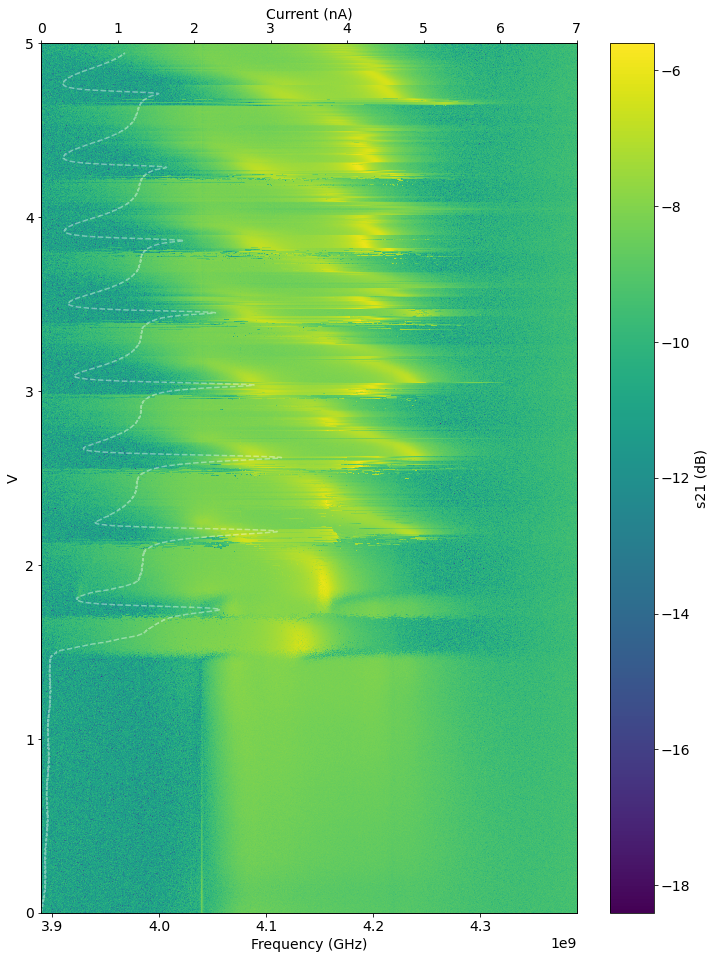

In [12]:
fig, ax1 = plt.subplots(figsize=(12,16))
voltage_scaling = 1e3
voltage_offset = 0.05
current_scaling = 1e9

ctf = ax1.pcolormesh(frq, v_bias, np.log(mag), shading='auto')
fig.colorbar(ctf, label='s21 (dB)')
ax1.set_ylabel('V')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylim([0,5])

ax2 =ax1.twiny()
ax2.plot(current_scaling*np.abs(i_up), voltage_scaling*v_up - voltage_offset, 'w--', alpha=0.4)
ax2.set_xlabel('Current (nA)');
ax2.set_xlim([0,7])

# plt.savefig('s21_dc_steps.png')

<h4>S21 as a function of MW tone power and frequency</h4>

In [13]:
# loading vna data
RUN_ID = 55
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()

RUN_ID = 36 # 36, 58
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_dc_dict = dataset.to_pandas_dataframe_dict()

<h4>Pump syncing VS DC</h4>

In [14]:
# loading vna data
RUN_ID = 92
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()

RUN_ID = 36 # 36, 58
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_dc_dict = dataset.to_pandas_dataframe_dict()

In [15]:
# IV curve
vnadc_dc_up_0 = vnadc_dc_dict['adwin_up_ramp']
vnadc_dc_up_1 = vnadc_dc_up_0.reset_index()
v_up = vnadc_dc_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = vnadc_dc_up_1['adwin_up_ramp'].to_numpy()

# down ramp
vnadc_dc_down_0 = vnadc_dc_dict['adwin_down_ramp']
vnadc_dc_down_1 = vnadc_dc_down_0.reset_index()
v_down = vnadc_dc_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = vnadc_dc_down_1['adwin_down_ramp'].to_numpy()

# divide into low-to-high and high-to-low
N = len(v_up)
zero_index_up = np.argmin(np.abs(i_up))
zero_index_down = np.argmin(np.abs(i_down))

v_dc_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
i_dc_lh = np.concatenate(( np.flip(i_down[zero_index_down:]), i_up[zero_index_up:] ))
v_dc_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
i_dc_hl = np.concatenate(( i_up[:zero_index_up], np.flip(i_down[:zero_index_down]) ))

# VNA spectra
vnadc_vna_0 = vnadc_vna_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq = np.reshape(frq, m_size)
v_bias = np.reshape(v_bias, m_size)
mag = np.reshape(mag, m_size)

(0.0, 3.0)

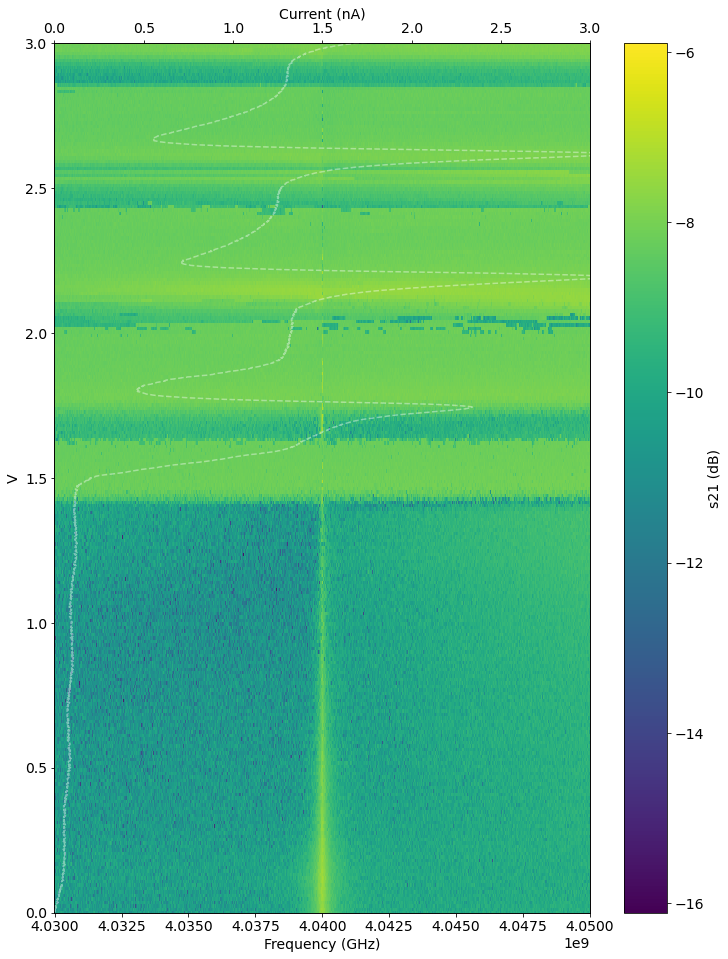

In [17]:
fig, ax1 = plt.subplots(figsize=(12,16))
voltage_scaling = 1e3
voltage_offset = 0.05
current_scaling = 1e9

ctf = ax1.pcolormesh(frq, v_bias, np.log(mag), shading='auto')
fig.colorbar(ctf, label='s21 (dB)')
ax1.set_ylabel('V')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylim([0,3])

ax2 =ax1.twiny()
ax2.plot(current_scaling*np.abs(i_up), voltage_scaling*v_up - voltage_offset, 'w--', alpha=0.4)
ax2.set_xlabel('Current (nA)');
ax2.set_xlim([0,3])

# plt.savefig('s21_dc_steps.png')

<h4>Pump syncing VS Flux</h4>

In [5]:
RUN_ID = 84
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()

In [8]:
# VNA spectra
vnadc_vna_0 = vnadc_vna_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
flux = vnadc_vna_1['current_source_current'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq = np.reshape(frq, m_size)
flux = np.reshape(flux, m_size)
mag = np.reshape(mag, m_size)

Text(0.5, 0, 'Frequency (GHz)')

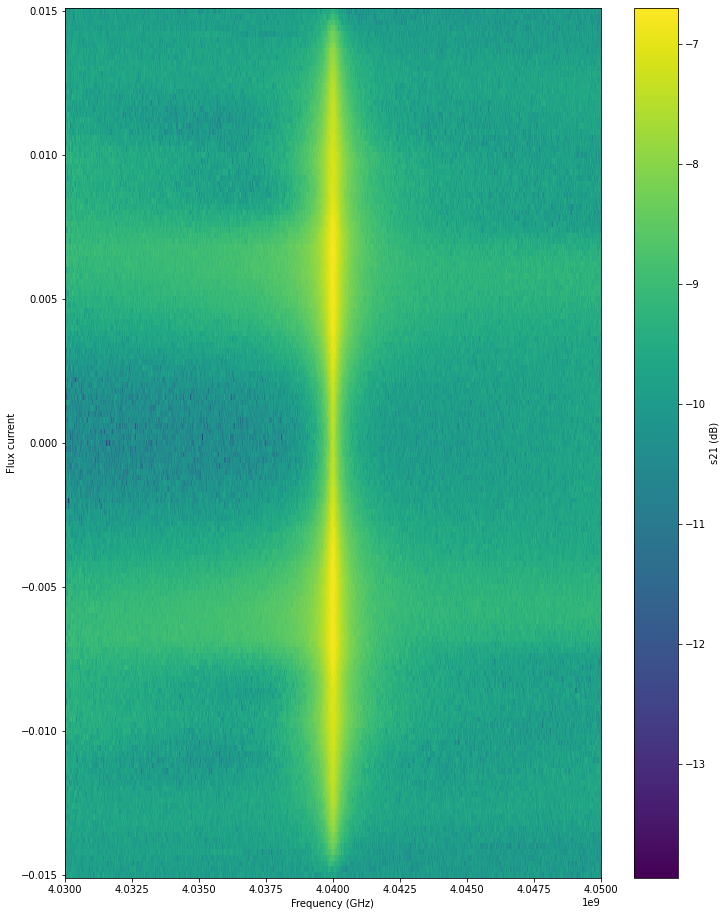

In [10]:
fig, ax1 = plt.subplots(figsize=(12,16))

ctf = ax1.pcolormesh(frq, flux, np.log(mag), shading='auto')
fig.colorbar(ctf, label='s21 (dB)')
ax1.set_ylabel('Flux current')
ax1.set_xlabel('Frequency (GHz)')